# Transformer model for language understanding

## Setup

In [1]:
# !pip install tensorflow
!pip install tensorflow_datasets
!pip install transformers
# !pip install -U "tensorflow-text==2.8.*"

  Using cached tensorflow_datasets-4.5.2-py3-none-any.whl (4.2 MB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached tqdm-4.63.0-py2.py3-none-any.whl (76 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached tensorflow_metadata-1.7.0-py3-none-any.whl (48 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 KB 1.7 MB/s eta 0:00:00a 0:00:01
  Using cached googleapis_common_protos-1.55.0-py2.py3-none-any.whl (212 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=cdd3e1d89ac417fe5dd4a603274aa13f2efe9ef067bf3d6928416b910b98d1b0
  Stored in directory: /home/nathan/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Succ

In [5]:
!pip install tensorflow>2.x

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-directml 1.15.5 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow-directml 1.15.5 requires tensorboard<1.16.0,>=1.15.0, but you have tensorboard 2.8.0 which is incompatible.


In [6]:
import json
from pathlib import Path
from random import randint

In [7]:
from tensorflow import keras
from IPython.display import clear_output

In [9]:
import collections
import logging
import os
# import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
tf.test.gpu_device_name()

2022-03-17 11:50:36.358615: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-03-17 11:50:36.368220: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdirectml.24bfac66e4ee42ec393a5fb471412d0177bc7bcf.so
2022-03-17 11:50:36.368359: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libdxcore.so
2022-03-17 11:50:36.370361: I tensorflow/stream_executor/platform/default/dso_loader.cc:97] Successfully opened dynamic library libd3d12.so
2022-03-17 11:50:36.737923: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:250] DirectML device enumeration: found 2 compatible adapters.
2022-03-17 11:50:36.738211: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:186] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3080 Laptop GPU
2022-03-17 11:50:36.825142: I tensorflow

'/device:DML:0'

In [26]:
project_path = '.'

In [11]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Download the Dataset

In [12]:
language = "en" #["en", "ar", "zh-cn", "zh-tw", "nl", "fr", "de", "it", "ja", "ko", "pl", "pt", "ru", "es", "th", "tr", "bg", "ca", "cs", "da", "el", "et", "fa", "fi", "he", "hi", "hr", "hu", "id", "lt", "lv", "ms", "no", "ro", "sk", "sl", "sr", "sv", "tl", "uk", "vi", "multilingual-64k", "multilingual-128k"]
hub_module = "https://tfhub.dev/google/wiki40b-lm-{}/1".format(language)
max_gen_len = 20 
# max gen len works how? not working yet
print("Using the {} model to generate sequences of max length {}.".format(hub_module, max_gen_len))

Using the https://tfhub.dev/google/wiki40b-lm-en/1 model to generate sequences of max length 20.


In [17]:
# print(list(tfds.list_builders()))

In [14]:
examples, metadata = tfds.load('wiki40b', with_info=True, try_gcs=True)
train_examples, val_examples = examples['train'], examples['validation']

In [15]:
train_examples = train_examples.prefetch(100)

The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

In [20]:
# for en_examples in train_examples.batch(3).take(1):

#   for en in en_examples:
#     print(en, en_examples.get(en))

## Text tokenization & detokenization

You can't train a model directly on text. The text needs to be converted to some numeric representation first. Typically, you convert the text to sequences of token IDs, which are used as indices into an embedding.

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

Download and unzip and import the `saved_model`:

In [21]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [22]:
# model_name = "ted_hrlr_translate_pt_en_converter"
# tf.keras.utils.get_file(
#     f"{model_name}.zip",
#     f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
#     cache_dir='.', cache_subdir='', extract=True
# )

In [23]:
# tokenizers = tf.saved_model.load(model_name)

In [27]:
# [item for item in dir(tokenizer) if not item.startswith('_')]

In [28]:
# for item in en_examples['text']:
#   item2 = item.numpy()
#   print(item2)
#   print(item2.decode('utf-8'))

In [30]:
# for item in en_examples['text']:
#   print(item)
# example_strings = [x.numpy().decode('utf-8').replace('\n', ' ') for x in en_examples['text']]
# print(example_strings[0], len(example_strings[0]))
# encoded = tokenizer.encode(example_strings[0])
# print(encoded, len(encoded))
# for row in encoded:
#   print(row)

The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [32]:
# round_trip = tokenizer.decode(encoded)
# print(round_trip)
# for line in round_trip.numpy():
#   print(line.decode('utf-8'))

The lower level `lookup` method converts from token-IDs to token text:

In [34]:
# tokens = tokenizer.lookup(encoded)
# tokens

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

This function will be used to encode the batches of raw text:

In [35]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [36]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

def tokenize_string(data_dict):

  # for en_examples in train_examples.batch(3).take(1):

  # for en in en_examples:
  #   print(en, en_examples.get(en))
  #   example_strings = [x.numpy().decode('utf-8').replace('\n', ' ') for x in en_examples['text']]
  # print(example_strings[0], len(example_strings[0]))
  # encoded = tokenizer.encode(example_strings[0])
  current_text = data_dict['text']
  # clean_text = current_text.numpy().decode('utf-8').replace('\n', ' ')
  # encoded_text = tokenizer.encode(clean_text)
  return current_text

In [40]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_string, num_parallel_calls=4)) # tf.data.AUTOTUNE)
      # .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [41]:
x_train = train_examples
# y_train,
x_test = val_examples
# , y_test

## Positional encoding

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [42]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [43]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


NotImplementedError: Cannot convert a symbolic Tensor (Reshape_1:0) to a numpy array.

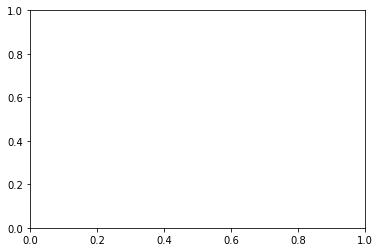

In [44]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [45]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [46]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor 'strided_slice_1:0' shape=(3, 1, 1, 5) dtype=float32>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [47]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [48]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor 'sub:0' shape=(3, 3) dtype=float32>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [49]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [50]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [51]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
Tensor("Softmax:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_1:0", shape=(1, 2), dtype=float32)


In [52]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
Tensor("Softmax_1:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_3:0", shape=(1, 2), dtype=float32)


In [53]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
Tensor("Softmax_2:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_5:0", shape=(1, 2), dtype=float32)


Pass all the queries together.

In [54]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
Tensor("Softmax_3:0", shape=(3, 4), dtype=float32)
Output is:
Tensor("MatMul_7:0", shape=(3, 2), dtype=float32)


## Multi-head attention

Description from Tensorflow tutorial:  
<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.

In the diagram above `(K,Q,V)` are passed through sepearte linear (`Dense`) layers for each attention head. For simplicity/efficiency the code below implements this using a single dense layer with `num_heads` times as many outputs. The output is rearranged to a shape of `(batch, num_heads, ...)` before applying the attention function.

The `scaled_dot_product_attention` function defined above is applied in a single call, broadcasted for efficiency. An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [55]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    # this should always be an even number, since dimension_of_model should 
    # always be dimension_of_each_head * number_of_heads_per_layer

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  
    # returns Tensor shape: (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  
    # returns Tensor shape: (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  
    # returns Tensor shape: (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [56]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([Dimension(1), Dimension(60), Dimension(512)]),
 TensorShape([Dimension(1), Dimension(8), Dimension(60), Dimension(60)]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [57]:
def point_wise_feed_forward_network(d_model, dimension_of_mlp):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dimension_of_mlp, activation='relu'),  
      # returns Tensor shape: (batch_size, seq_len, dimension_of_mlp)
      tf.keras.layers.Dense(d_model)  
      # returns Tensor shape: (batch_size, seq_len, d_model)
  ])

In [58]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([Dimension(64), Dimension(50), Dimension(512)])

### Decoder

### Decoder layer

  Each decoder layer consists of sublayers:

  1.   Masked multi-head attention (with look ahead mask and padding mask)
  2.   Point wise feed forward networks (aka MLP multi-layer peceptron)

  Each of these sublayers has a residual connection around it followed by 
  a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. 
  The normalization is done on the `d_model` (last) axis.

  There are N decoder layers in the transformer.

In [59]:
class DecoderLayerAttnOnly(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dimension_of_mlp='unused', rate=0.1):
    super(DecoderLayerAttnOnly, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)

  def call(self, x, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)

    # here is where I'll put the VAE, on the attn1

    out1 = self.layernorm1(attn1 + x) # I think x is the residual stream here

    return out1, attn_weights_block1




In [60]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, dimension_of_mlp, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dimension_of_mlp) # aka MLP, multi-layer perceptron

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
    # attn1.shape: (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)

    # here is where I'll put the compression (e.g. infoVAE), on the attn1

    out1 = self.layernorm1(attn1 + x) # I think x is the residual stream here

    ffn_output = self.ffn(out1)  
    # returns Tensor shape: (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout2(ffn_output, training=training)

    # here is where I could put a second VAE on the ffn_output
    
    out2 = self.layernorm2(ffn_output + out1)  
    # returns Tensor shape: (batch_size, target_seq_len, d_model)

    return out2, attn_weights_block1


In [61]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dimension_of_mlp, target_vocab_size,
               maximum_position_encoding, rate=0.1, attention_only=False):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = ([DecoderLayerAttnOnly(d_model, num_heads, dimension_of_mlp, rate)
                       for _ in range(num_layers)] if attention_only else 
                       [DecoderLayer(d_model, num_heads, dimension_of_mlp, rate)
                       for _ in range(num_layers)])

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  
    # returns Tensor shape: (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1 = self.dec_layers[i](x, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}'] = block1


    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights



In [62]:
# test sample initialization of the decoder layer
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)),
    False, None, None)

print('sample_decoder_layer_output.shape',sample_decoder_layer_output.shape)   
# returns Tensor shape: (batch_size, target_seq_len, d_model)

# and the full Decoder wrapper...

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dimension_of_mlp=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2'].shape

sample_decoder_layer_output.shape (64, 50, 512)


(TensorShape([Dimension(64), Dimension(26), Dimension(512)]),
 TensorShape([Dimension(64), Dimension(8), Dimension(26), Dimension(26)]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [63]:
class Transformer(tf.keras.Model):
  def __init__(self, decoder_num_layers, d_model, num_heads, dimension_of_mlp, 
               vocab_size,
               max_position_encoding, rate=0.1, attention_only=False):
    super().__init__()
    self.decoder = Decoder(decoder_num_layers, d_model, num_heads, dimension_of_mlp,
                             vocab_size, max_position_encoding, rate=rate, 
                           attention_only=attention_only)

    self.final_layer = tf.keras.layers.Dense(vocab_size)
    self.max_position_encoding = max_position_encoding

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    padding_mask, look_ahead_mask = self.create_masks(inputs)

    output, attention_weights = self.decoder(inputs, training, look_ahead_mask, padding_mask)  
    # returns Tensor shape: (batch_size, inp_seq_len, d_model)

    final_output = self.final_layer(output)  
    # returns Tensor shape:(batch_size, inp_seq_len, vocab_size)

    return final_output, attention_weights

  def create_masks(self, inputs):
    padding_mask = create_padding_mask(inputs)
    look_ahead_mask = create_look_ahead_mask(tf.shape(inputs)[1])
    look_ahead_mask = tf.maximum(padding_mask, look_ahead_mask)
    return padding_mask, look_ahead_mask


In [64]:
temp_max_position_encoding = 20
sample_transformer = Transformer(
    decoder_num_layers=2, d_model=512, num_heads=8, dimension_of_mlp=2048,
    vocab_size=8000,
    max_position_encoding=temp_max_position_encoding, attention_only=True)

temp_batch_size = 64
temp_input = tf.random.uniform((temp_batch_size, temp_max_position_encoding), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([Dimension(64), Dimension(20), Dimension(8000)])

## Set hyperparameters

The details from Tranformer Circuit team's initial paper

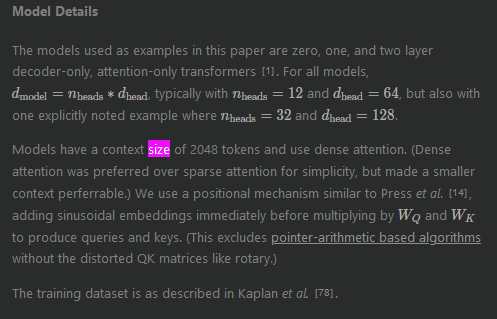

In [65]:

from pprint import pprint
hyperparameters = {
    'batch_size':64,
    'decoder_num_layers':2,
    'num_heads_per_layer':12, 
    'dimensions_per_head': 64,
    'dropout_rate':0.1,
    'model_context_tokens': 20, # using also as max_positional_encoding for this purpose
    # context tokens set to much smaller than TC's 2048 for now for training speed
    'attention_only':True,
    'epochs':2,
    'vocab_size':tokenizer.vocab_size,
    'metrics':['loss', 'accuracy', 'val_loss', 'val_accuracy']
}
# dimension_of_model (d_model) originally set in example code to 128
hyperparameters['d_model'] = (hyperparameters['num_heads_per_layer'] * 
                              hyperparameters['dimensions_per_head']
)
# dimension_of_mlp originally set in example code to 4 * d_model = 512
hyperparameters['dimension_of_mlp'] = hyperparameters['d_model'] * 4
hyperparameters['model_name'] = f"Decoder_\
{hyperparameters['decoder_num_layers']}layer_\
{hyperparameters['num_heads_per_layer']}head_\
{'attnOnly' if hyperparameters['attention_only'] else 'mlp'}_\
v1"
pprint(hyperparameters)

{'attention_only': True,
 'batch_size': 64,
 'd_model': 768,
 'decoder_num_layers': 2,
 'dimension_of_mlp': 3072,
 'dimensions_per_head': 64,
 'dropout_rate': 0.1,
 'epochs': 2,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy'],
 'model_context_tokens': 20,
 'model_name': 'Decoder_2layer_12head_attnOnly_v1',
 'num_heads_per_layer': 12,
 'vocab_size': 50257}


In [66]:
# planing tests to run on varying compression
# compression_ratio = vae_latent_size / d_model 
vae_latent_space_sizes = [1,5,10,20,50,100,200]
compression_ratios = [x / hyperparameters['d_model'] for x in vae_latent_space_sizes]
print(zip(vae_latent_space_sizes, compression_ratios))

In [67]:
special_tokens = ['_START_ARTICLE_', '_START_SECTION_', '_START_PARAGRAPH_', '_NEWLINE_']
paragraph_token = '_START_PARAGRAPH_'
newline_token = '_NEWLINE_'

In [68]:
def convert_wikidata_to_tokens(data):
  encoded_tensors = []
  for inp in data:
    split_text = inp.numpy().decode('utf-8').replace('\n', ' ').replace(newline_token, '\n').split(' ')
    paragraph_start = split_text.index(paragraph_token) + 1 if paragraph_token in split_text else None
    if paragraph_start is None:
      continue
    # only encode as many words as we need context tokens
    raw_text = ' '.join(split_text[paragraph_start: hyperparameters['model_context_tokens'] + paragraph_start + 1])

    # need to trim encoded_text since some things like punctuation become tokens
    encoded_text = tokenizer.encode(raw_text)[:hyperparameters['model_context_tokens']]

    encoded_tensor = tf.constant(encoded_text)

    # if there are tensors shorter than the desired length, need to left pad them
    if encoded_tensor.shape[0] < hyperparameters['model_context_tokens']:
      padding = tf.constant([[hyperparameters['model_context_tokens'] - encoded_tensor.shape[0], 0]])
      encoded_tensor = tf.pad(encoded_tensor, padding)

    encoded_tensors.append(encoded_tensor)
  
  return tf.stack(encoded_tensors)

In [74]:
raw_val = val_examples.batch(3).take(1)

print(raw_val, type(raw_val)) 
print(raw_val.__dict__)
for item in val_examples.batch(10000).take(1):
    raw_val = item
    break
val_sample = convert_wikidata_to_tokens(raw_val.get('text'))


<DatasetV1Adapter shapes: {text: (?,), version_id: (?,), wikidata_id: (?,)}, types: {text: tf.string, version_id: tf.string, wikidata_id: tf.string}> <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
{'_dataset': <TakeDataset shapes: {text: (?,), version_id: (?,), wikidata_id: (?,)}, types: {text: tf.string, version_id: tf.string, wikidata_id: tf.string}>, '_variant_tensor_attr': <tf.Tensor 'TakeDataset_8:0' shape=() dtype=variant>, '_self_setattr_tracking': True, '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_variant_tracker', ref=<tensorflow.python.data.ops.dataset_ops._VariantTracker object at 0x7f238be44a90>)], '_self_unconditional_dependency_names': {'_variant_tracker': <tensorflow.python.data.ops.dataset_ops._VariantTracker object at 0x7f238be44a90>}, '_self_unconditional_deferred_dependencies': {}, '_self_update_uid': -1, '_self_name_based_restores': set(), '_variant_tracker': <tensorflow.python.data.ops.dataset_ops._VariantTracker obje

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [75]:
# Nathan says: I don't yet understand why it is necessary for the learning rate schedule
# to be proportional to the dimension of the model. I should do more background reading.

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [76]:
learning_rate = CustomSchedule(hyperparameters['d_model'])

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

AttributeError: 'Tensor' object has no attribute 'ndim'

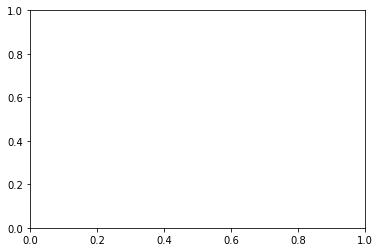

In [77]:
temp_learning_rate_schedule = CustomSchedule(hyperparameters['d_model'])

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [78]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [79]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  # print(real, pred)
  argmax_pred = tf.argmax(pred, axis=2, output_type=tf.dtypes.int32)
  # print(argmax_pred)
  accuracies = tf.equal(real, argmax_pred)

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # print(mask)
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [80]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.Mean(name='validation_accuracy')

## Training and checkpointing

In [81]:

transformer = Transformer(
    decoder_num_layers=hyperparameters['decoder_num_layers'],
    d_model=hyperparameters['d_model'],
    num_heads=hyperparameters['num_heads_per_layer'],
    dimension_of_mlp=hyperparameters['dimension_of_mlp'],
    vocab_size=hyperparameters['vocab_size'],
    max_position_encoding=hyperparameters['model_context_tokens'],
    rate=hyperparameters['dropout_rate'])

In [82]:
# Create the checkpoint path and the checkpoint manager. 
# This will be used to save checkpoints every `n` epochs.

def save_metadata_to_json(checkpoint_path, hyperparameters, history, epoch, batch):
  custom_metadata = {'history':history, 'hyperparameters':hyperparameters, 'epoch':epoch, 'batch':batch}
  with open(f"{checkpoint_path}/metadata.json", 'w') as f:
    json.dump(custom_metadata, f)

def load_metadata_from_json(checkpoint_path, hyperparameters):
  custom_metadata = {}
  with open(f"{checkpoint_path}/metadata.json", 'r') as f:
    custom_metadata = json.load(f)
  return custom_metadata

In [83]:
# Uncomment this for resetting checkpoint manager for debugging purposes
# ckpt_manager = None
# ckpt = None

In [84]:
checkpoint_path = f"{project_path}/models/{hyperparameters['model_name']}/train"
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
custom_metadata = {}
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  custom_metadata = load_metadata_from_json(checkpoint_path, hyperparameters)
  loaded_hyperparameters = custom_metadata['hyperparameters']
  print('loaded hyperparameters:')
  pprint(loaded_hyperparameters)
  for item in loaded_hyperparameters:
    if hyperparameters.get(item) != loaded_hyperparameters[item]:
      print(f'''mismatch of {item} between hyperparameters: 
      current {hyperparameters.get(item)}, loaded {loaded_hyperparameters[item]}''')
  for item in hyperparameters:
    if hyperparameters[item] != loaded_hyperparameters.get(item):
      print(f'''mismatch of {item} between hyperparameters: 
      current {hyperparameters.get(item)}, loaded {loaded_hyperparameters.get(item)}''')
  metrics = hyperparameters['metrics']
  history = custom_metadata['history']
  print(f'Latest checkpoint restored!! {ckpt_manager.latest_checkpoint}')
else:
  metrics = hyperparameters['metrics']
  history = {}
  for m in metrics:
    history[m] = []
  print('No checkpoint found. Starting fresh')

No checkpoint found. Starting fresh


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
  # # Uncomment to reset the history for debugging
  # history = {}
  # for m in metrics:
  #   history[m] = []

In [85]:
print(val_sample[0:0 + hyperparameters['batch_size'], 0:-1])

NameError: name 'val_sample' is not defined

In [86]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32)
]


# @tf.function(input_signature=train_step_signature)
def train_step(inp):
  # print(type(inp), inp.shape)
  input = inp[:, 0:-1]
  # print(type(inp), inp.shape)
  target = inp[:, 1:]

  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(input,
                                 training = True)
    loss = loss_function(target, predictions)
    

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(accuracy_function(target, predictions))
  
def val_step(val_inputs):
  val_input = val_inputs[:, 0:-1]
  val_target = val_inputs[:, 1:]
  val_predictions, _ = transformer(val_input, training = False)
  val_loss = loss_function(val_target, val_predictions)
  validation_loss(val_loss)
  validation_accuracy(accuracy_function(val_target, val_predictions))

In [87]:
current_epoch = custom_metadata.get('epoch', 1)
current_batch_num = custom_metadata.get('batch', 1)
print('Hyperparameters:')
pprint(hyperparameters)
print(f"training epochs from {current_epoch} to {hyperparameters['epochs']}")
print('current_batch_num:', current_batch_num)
for epoch in range(current_epoch, hyperparameters['epochs'] + 1):
  start = time.time()
  custom_metadata['epoch'] = epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  validation_loss.reset_states()
  validation_accuracy.reset_states()

  batch_num = current_batch_num
  current_batch_num = 1
  for inputs in train_batches:
    stacked_tensors = convert_wikidata_to_tokens(inputs)

    train_step(stacked_tensors)
    val_count = 0
    for i in range(0, 10000 - hyperparameters['batch_size'], hyperparameters['batch_size']):
      if randint(0, 18) < 18 and (val_count > 8 or i < 5000):
        continue
      val_step(val_sample[i:i + hyperparameters['batch_size'], :])
      val_count += 1

    batch_num += 1
    custom_metadata['batch'] = batch_num
    current_metrics = {'loss': train_loss.result(), 
                       'accuracy': train_accuracy.result(),
                       'val_loss': validation_loss.result(),
                       'val_accuracy': validation_accuracy.result(),
                       'val_samples': val_count}
    for metric in metrics:
      history[metric] += [float(current_metrics[metric])]
   
    if batch_num % 20 == 0:
      clear_output(wait=True)
      f, axs = plt.subplots(1, len(['loss', 'accuracy']), figsize=(15,5))
      print(f'Epoch {epoch} Batch {batch_num} Loss {train_loss.result():.4f} \
      Accuracy {train_accuracy.result():.4f} Val samples {val_count}', flush=True)
      for i, metric in enumerate(['loss', 'accuracy']): 
        axs[i].plot(range(len(history[metric])), 
                    history[metric], 
                    label='train_' + metric)
        if history.get('val_' + metric):
            axs[i].plot(range(len(history[metric])), 
                        history['val_' + metric], 
                        label='val_' + metric)
            
        axs[i].legend()
        axs[i].grid()
        axs[i].set_title(metric)
      plt.tight_layout()
      plt.show()
      
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()
      
    if batch_num % 100 == 0:
      ckpt_save_path = ckpt_manager.save()
      save_metadata_to_json(checkpoint_path, hyperparameters, history, epoch, batch_num)
      print(f'Saving checkpoint for epoch {epoch} batch {batch_num} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} \
  Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {(time.time() - start) / 60.0:.2f} minutes\n')

Hyperparameters:
{'attention_only': True,
 'batch_size': 64,
 'd_model': 768,
 'decoder_num_layers': 2,
 'dimension_of_mlp': 3072,
 'dimensions_per_head': 64,
 'dropout_rate': 0.1,
 'epochs': 2,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy'],
 'model_context_tokens': 20,
 'model_name': 'Decoder_2layer_12head_attnOnly_v1',
 'num_heads_per_layer': 12,
 'vocab_size': 50257}
training epochs from 1 to 2
current_batch_num: 1


RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.